# Microsoft Malware detection

In this kernel, I build a LGBM model using only a subset of the training data, in order to fit in memory.

## Notebook  Content
1. [Utility functions](#0)
1. [Loading the data](#1) <br>
    2.1 [Get the files and select the variables](#2.1) <br>
    2.2 [Define the type of each variable](#2.2)
1. [Feature engineering](#2) <br>
    3.1 [Frequency encoding](#3.1) <br>
    3.2 [Label encoding](#3.2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

<a id="0"></a> <br>
## 1. Utility functions
Before starting, we define a utility function that helps managing memory.

In [1]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<a id="1"></a> <br>
## 2. Loading the data

In [2]:


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from sklearn import metrics
# Plotly library
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.plotly as py
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)

<a id="2.1"></a> <br>
### 2.1 Get the files and select the variables
Following [Theo Viel](https://www.kaggle.com/theoviel/load-the-totality-of-the-data), we set the types of each fields in the train set in order to reduce the memory usage:

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }


First, we make a census of the variables, by type, and define the set we want to keep before reading the data:

In [4]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [5]:
dcols =['MachineIdentifier','Platform','Census_ProcessorClass','OsPlatformSubRelease','Census_IsPortableOperatingSystem',
 'HasTpm','Census_IsPenCapable','ProductName','Census_IsFlightsDisabled',
 'Census_FlightRing','UacLuaenable','Census_DeviceFamily',
 'PuaMode','IsBeta', 'AutoSampleOptIn']

We read the data, limiting the size of the training set to 4'000'000 rows:

In [6]:
%%time
nrows = 500000
#_______________________________________________________________________________
retained_columns = numerical_columns + categorical_columns
#retained_columns = [c for c in retained_columns if c not in dcols]
train = pd.read_csv('I:\Data/train.csv',
                    nrows = nrows,
                    usecols = retained_columns,
                    dtype = dtypes)

Wall time: 34 s


In [7]:
gc.collect()

13272

<a id="2.2"></a> <br>
### 2.2 Define the type of each variable
In practice, among the numerical variables, many corresponds to identifiers. *In the current dataset, the truly numerical variables are in fact rare*. Below, I make a list of the variables which are truly numerical, according the the description of the data.

In [8]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]


We also list binary variables, since they can be treated as numericals by tree methods:

In [9]:
binary_variables = [c for c in train.columns if train[c].nunique() == 2]

to finally make a census of the categorical variables:

In [10]:
categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

### 2.3 Exploratory Data Analysis

First, let's examine the distribution of data types in the dataset.

In [11]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=800)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

Most of the current variables are categories and we need to choose a method to treat them. **Depending on the cardinality of each variable**, we can opt for** one-hot-encoding, frequency or target encoding**. In the particular case of Light-GBM, we can also use the **built-in LGBM treatment of categoricals**:

In [12]:
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [13]:
train.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,500000.000000,498126.0,500000.000000,2.430200e+04,497969.000000,497969.0,497969.0,500000.000000,500000.000000,481791.000000,345642.0,499997.0,500000.000000,500000.000000,500000.000000,497980.0,500000.000000,469942.000000,496625.0,494821.0,499387.000000,494730.0,494342.000000,497653.0,497653.0,497650.0,4.970340e+05,4.970340e+05,500000.000000,495470.000000,497260.000000,497266.0,497266.0,4.848750e+05,500000.000000,500000.000000,496682.0,500000.000000,500000.000000,84845.000000,491103.000000,182487.000000,489740.0,491044.000000,500000.000000,182927.0,499090.000000,500000.000000,500000.000000,496026.000000,482909.0,482909.0,500000.000000
mean,0.000010,NaN,0.017286,inf,47774.417969,NaN,NaN,0.987822,107.999314,81284.453125,NaN,NaN,27.776362,15718.549790,575.487154,NaN,0.000028,0.000458,NaN,NaN,0.995112,NaN,238797.359375,NaN,NaN,NaN,5.119288e+05,3.771926e+05,0.076776,6123.438965,NaN,NaN,NaN,1.123827e+09,15834.204674,967.362286,NaN,60.461090,0.000636,0.000012,0.000008,0.000290,NaN,33013.386719,0.486768,0.0,0.006958,0.125776,0.037976,0.056915,NaN,NaN,0.500768
std,0.003162,0.0,0.130335,inf,14024.211914,0.0,0.0,0.109680,62.959880,48920.117188,0.0,NaN,65.630390,2192.160343,248.009244,0.0,0.005291,0.021393,NaN,0.0,0.233560,NaN,72023.726562,0.0,0.0,NaN,3.601384e+05,3.293805e+05,0.266236,5285.255371,0.000000,NaN,NaN,1.893357e+09,1961.162449,2916.256903,0.0,44.985093,0.025211,0.003435,0.002857,0.017029,NaN,21193.039062,0.499825,0.0,0.083130,0.331597,0.191138,0.232056,0.0,0.0,0.500000
min,0.000000,0.0,0.000000,1.000000e+00,39.000000,1.0,0.0,0.000000,1.000000,5.000000,1.0,1.0,-127.000000,7600.000000,16.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,9.0,14.000000,1.0,1.0,10.0,0.000000e+00,0.000000e+00,0.000000,512.000000,3.900391,-1.0,-1.0,0.000000e+00,7601.000000,0.000000,1.0,5.000000,0.000000,0.000000,0.000000,0.000000,9.0,5.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000
25%,0.000000,7.0,0.000000,7.880000e+02,49480.000000,1.0,1.0,1.000000,51.000000,36825.000000,18.0,89.0,-29.000000,15063.000000,256.000000,1.0,0.000000,0.000000,111.0,1.0,1.000000,1443.0,189586.000000,2.0,5.0,1998.0,2.393720e+05,1.207850e+05,0.000000,4096.000000,13.898438,1366.0,768.0,0.000000e+00,15063.000000,165.000000,8.0,31.000000,0.000000,0.000000,0.000000,0.000000,142.0,13169.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,3.0,0.000000
50%,0.000000,7.0,0.000000,1.632000e+03,53447.000000,1.0,1.0,1.000000,97.000000,82373.000000,27.0,181.0,58.000000,16299.000000,768.000000,1.0,0.000000,0.000000,117.0,1.0,1.000000,2102.0,246715.000000,4.0,5.0,2500.0,4.769400e+05,2.494760e+05,0.000000,4096.000000,15.500000,1366.0,768.0,0.000000e+00,16299.000000,285.000000,9.0,34.000000,0.000000,0.000000,0.00

Since most of the data is categorical, pandas "describe" built-in function is not really informative. So, let's make our own describe report.

In [13]:
#%%time
# checking missing data
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/len(train)*100).sort_values(ascending = False)
first = np.zeros(len(train.columns))
second = np.zeros(len(train.columns))
third = np.zeros(len(train.columns))
typelist = list()
num_unique = np.zeros(len(train.columns))
for i, col in enumerate(total.index):
    num_unique[i] = train[col].nunique()
    typelist.append('Binary' if (col in binary_variables) else 'Numeric' if (col in true_numerical_columns) else 'Category')
    first[i] = list(train[col].value_counts())[0]/len(train)*100
    second[i] = list(train[col].value_counts())[1]/len(train)*100 if train[col].nunique()>1 else 0
    third[i] = list(train[col].value_counts())[2]/len(train)*100 if train[col].nunique()>2 else 0

typelistdf = pd.DataFrame(data ={'Type': typelist})
firstdf = pd.DataFrame(data ={'1st Category':first})
seconddf = pd.DataFrame(data={'2nd Category':second})
thirddf = pd.DataFrame(data={'3rd Category':third})
num_uniquedf = pd.DataFrame(data={'Unique values': num_unique})
missing_train_data  = pd.concat([total, percent], 
                                axis=1, keys=['Total', 'Percentage of Missing']).reset_index()
missing_train_data = pd.concat([missing_train_data, num_uniquedf, typelistdf, firstdf, seconddf, thirddf], axis=1)
missing_train_data.head(len(train.columns))

,index,Total,Percentage of Missing,Unique values,Type,1st Category,2nd Category,3rd Category
0,PuaMode,499878,99.9756,1.0,Category,0.0244,0.0000,0.0000
1,Census_ProcessorClass,497900,99.5800,3.0,Category,0.2338,0.1152,0.0710
2,DefaultBrowsersIdentifier,475698,95.1396,525.0,Category,0.5142,0.4712,0.3148
3,Census_IsFlightingInternal,415155,83.0310,2.0,Binary,16.9688,0.0002,0.0000
4,Census_InternalBatteryType,355142,71.0284,28.0,Category,22.7218,2.7564,2.0848
5,Census_ThresholdOptIn,317513,63.5026,2.0,Binary,36.4868,0.0106,0.0000
6,Census_IsWIMBootEnabled,317073,63.4146,1.0,Category,36.5854,0.0000,0.0000
7,SmartScreen,178295,35.6590,12.0,Category,48.3342,11.7560,2.0916
8,OrganizationIdentifier,154358,30.8716,43.0,Category,47.0896,19.6550,0.7226
9,SMode,30058,6.0116,2.0,Binary,93.9454,0.0430,0.0000


In [68]:
train.Census_DeviceFamily.value_counts()

Windows.Desktop    499192
Windows.Server        808
Name: Census_DeviceFamily, dtype: int64

+ PuaMode, Census_ProcessorClass, DefaultBrowsersIdentifier, Census_IsFlightingInternal, Census_InternalBatteryType, Census_ThresholdOptIn, and Census_IsWIMBootEnabled have over 60% null data.
+ Let's examine these features first and check their distribution regarding to the target.

### 2.3.1 PuaMode: Categorical
#### Description: Pua Enabled mode from the service

This feature has only 1 unique value and about %99.98 of it is missing. The best thing to do is just to remove it.

In [14]:
del train['PuaMode']
categorical_columns.remove('PuaMode')

### 2.3.2 Census_ProcessorClass: Categorical
#### Description: A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
+ The last sentence is telling us why we have so many missing data

In [15]:
d = train[['Census_ProcessorClass', 'HasDetections']]
d = d.astype('object').fillna("missing")
infected = list()

for item in d.Census_ProcessorClass.unique().tolist():
        a = (d.Census_ProcessorClass==item).sum()
        infected.append((d[d['Census_ProcessorClass']==item]["HasDetections"]==1).sum()/a)
        
oneclass = np.array(infected)
zeroclass = 1 - oneclass

trace1 = go.Bar(x=d.Census_ProcessorClass.value_counts().index.tolist(), y=oneclass.tolist(), name= 'Has Detections')
trace2 = go.Bar(x=d.Census_ProcessorClass.value_counts().index.tolist(), y=zeroclass.tolist(),name='No Detections')
trace3 = go.Pie(labels=d.Census_ProcessorClass.unique().tolist(), values=d.Census_ProcessorClass.value_counts().tolist())

data = [trace1, trace2]
layout = go.Layout(barmode='group')

fig = go.Figure(data=data, layout=layout)
iplot(fig)

data=[trace3]
layout = go.Layout()
fig=go.Figure(data=data, layout=layout)
iplot(fig)

Though there is a lot of missing data, I will keep this feature because if you noticed as processor class goes up, the chance of infection increases too. So, this feature might be helpful in combination with other features.

### 2.3.3 DefaultBrosersIdentifier: Categorical
#### Description: ID for the machine's default browser

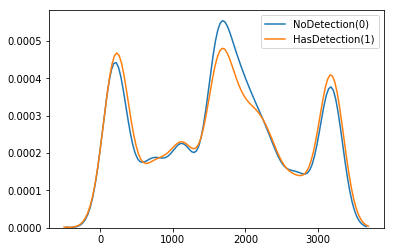

In [142]:
sns.kdeplot(train.loc[train['HasDetections'] == 0, 'DefaultBrowsersIdentifier'], label='NoDetection(0)')
sns.kdeplot(train.loc[train['HasDetections'] == 1, 'DefaultBrowsersIdentifier'], label='HasDetection(1)')
plt.show()

Since the two plots are not the same, this feature is informative for our model. so we'll keep it.

### 2.3.4 Census_IsFightingInternal: Binary
#### Description: NA

In [16]:
train.Census_IsFlightingInternal.value_counts()

0.0    84844
1.0        1
Name: Census_IsFlightingInternal, dtype: int64

More than 80 percent of this feature is missing and the rest of it has almost only 1 value. Hence, it's just a waste of memory.

In [17]:
del train['Census_IsFlightingInternal']
binary_variables.remove('Census_IsFlightingInternal')

### 2.3.5 Census_InternalBatteryType: Categorical
#### Description: NA

In [18]:
train. Census_InternalBatteryType.value_counts()

lion    113609
li-i     13782
#        10424
lip       3530
liio      1854
li p       448
li         371
nimh       256
real       148
pbac       127
bq20       120
vbox        86
unkn        22
lgi0        21
lipp        12
lipo        12
4cel         9
lhp0         6
batt         5
ithi         4
bad          3
ram          2
virt         2
ca48         1
lit          1
a140         1
asmb         1
lio         1
Name: Census_InternalBatteryType, dtype: int64

<a id="2"></a> <br>
## 3. Feature Engineering
<a id="3.1"></a> <br>
### 3.1 Frequency encoding
For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their frequencies. These variables are then treated as numerical.

In [19]:
def frequency_encoding(variable, df):
    #t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    if(df==1):
        t = train[variable].value_counts().reset_index()
    else:
        t = test[variable].value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [20]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'AVProductStatesIdentifier',# I added this one
    'DefaultBrowsersIdentifier'# And deleted this one
]



In [21]:
train_categorical_columns = categorical_columns.copy()
test_categorical_columns = categorical_columns.copy()
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable, 1)
    train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    #test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    train_categorical_columns.remove(variable)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.24it/s]


<a id="3.2"></a> <br>
### 3.2 Label encoding

In [27]:
#for col in tqdm(train_categorical_columns):
#    if col == 'MachineIdentifier': continue
#    train[col] = pd.factorize(train[col], sort=True)[0].astype('int32')

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.30it/s]


In [22]:

indexer = {}
for col in tqdm(train_categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(train[col])
    
for col in tqdm(train_categorical_columns):
    if col == 'MachineIdentifier': continue
    train[col] = indexer[col].get_indexer(train[col])
    #test[col] = indexer[col].get_indexer(test[col])


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  4.69it/s]


In [ ]:
#train.groupby('Processor')['Processor'].transform('count')
gc.collect()

In [ ]:
#train_new = train.copy()

In [ ]:
"""
count_cols = ["Processor", "Census_PrimaryDiskTypeName", "Census_OSArchitecture", 
             "Census_OSInstallTypeName", "Census_OSWUAutoUpdateOptionsName",
             "AVProductsInstalled", "AVProductsEnabled"]
#for col in count_cols:
for col in categorical_columns:
    train_new[col+"_count"] = train_new.groupby(col)[col].transform('count')
    """

In [ ]:
#len(train_new.columns)

In [ ]:
#count_cols = ["Processor_count", "Census_PrimaryDiskTypeName_count", "Census_OSArchitecture_count", 
#             "Census_OSInstallTypeName_count", "Census_OSWUAutoUpdateOptionsName_count",
#             "AVProductsInstalled_count", "AVProductsEnabled_count"]
#train.drop(columns=count_cols, inplace=True)

In [23]:
train = reduce_mem_usage(train)

Mem. usage decreased to 35.72 Mb (74.5% reduction)


In [24]:
target = train['HasDetections']
del train['HasDetections']

KeyError: 'HasDetections'

In [ ]:
"""
eval_set = train_new.sample(frac=0.2, random_state=10)
train_new.drop(eval_set.index, inplace=True)
gc.collect()
"""

<a id="3"></a> <br>
## 3. Training the model

In [ ]:
param = {'num_leaves': 90,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.12,
         "boosting": "gbdt",
         "feature_fraction": 0.4,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.25,
         "random_state": 133,
         'max_bin': 511,
         "verbosity": -1}

In [ ]:
"""
features = [c for c in train_new.columns if c not in ['MachineIdentifier']]
trn_data = lgb.Dataset(train_new[features],
                           label=target.iloc[train_new.index],
                           categorical_feature = train_categorical_columns
                          )
val_data = lgb.Dataset(eval_set[features],
                           label=target.iloc[eval_set.index],
                           categorical_feature = train_categorical_columns
                          )

num_round = 10000
clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
preds = clf.predict(eval_set[features], num_iteration=clf.best_iteration)    
auc_score = metrics.roc_auc_score(target.iloc[eval_set.index], preds)
print("AUC score: {:<8.5f}".format(auc_score))
"""

We set the max number of iteration over folds:

In [ ]:
max_iter = 5

In [ ]:
gc.collect()

In [25]:
def model_training(train_categorical_columns):
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    train_categorical_columns = [c for c in train_categorical_columns if c not in ['MachineIdentifier']]
    features = [c for c in train.columns if c not in ['MachineIdentifier']]
    folds_clfs = list()
    score = [0 for _ in range(folds.n_splits)]
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = train_categorical_columns
                          )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = train_categorical_columns
                          )

        num_round = 10000
        clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=50,
                    early_stopping_rounds = 100)
        folds_clfs.append(clf)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
        score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
        if fold_ == max_iter - 1: break
    
    if (folds.n_splits == max_iter):
        cv_score = metrics.roc_auc_score(target, oof)
        print("CV score: {:<8.5f}".format(cv_score))
    else:
        cv_score = sum(score) / max_iter
        print("CV score: {:<8.5f}".format(cv_score))
    return cv_score, folds_clfs


In [ ]:
best_score = 0

In [ ]:
len(train.columns)

In [ ]:
#for col in categorical_columns:
    #train[col+"_count"] = train.groupby(col)[col].transform('count')
#    del train[col+"_count"]

In [ ]:
%%time
cv_score, clfs = model_training(train_categorical_columns)
if(cv_score>best_score):
    print("CV score improved by {}".format(cv_score - best_score))
    best_score = cv_score
    best_params = param
else:
    print("CV score decreased by {}".format(cv_score - best_score))
    

In [ ]:
#best_score = cv_score
#print(best_score)

In [ ]:
"""
%%time
for col in categorical_columns:
    train[col+"_count"] = train.groupby(col)[col].transform('count')
    cv_score, clfs = model_training(train_categorical_columns)
    print("CV score changed by {} = {}".format(col, cv_score-best_score))
    del train[col+"_count"]
    """

In [ ]:
"""
%%time
added_features = list()
for i, col in enumerate(categorical_columns):
    print("feature # {}/{}".format(i+1, len(categorical_columns)))
    train[col+"_count"] = train.groupby(col)[col].transform('count')
    cv_score, clfs = model_training(train_categorical_columns)
    if(cv_score > best_score):
        print("CV score improved by {} = {}".format(col, cv_score-best_score))
        added_features.append(col)
        best_score = cv_score
    else:
        print("{} was not useful".format(col))
        del train[col+"_count"]
        """

<a id="4"></a> <br>
## 4. Feature importance

In [ ]:
def get_feature_imp(clfs, features, top_number = 1000):
    feature_importance_df = pd.DataFrame()
    for i, clf in enumerate(clfs, 1):
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = i+1
    feature_importance_df = pd.concat([feature_importance_df, 
                                           fold_importance_df], axis=0)
        
    cols = (feature_importance_df[["feature", "importance"]].groupby("feature").mean()
        .sort_values(by="importance", ascending=False)[:top_number].index)

    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    best_features = best_features[["feature", "importance"]].groupby('feature').mean().reset_index()
    best_features.sort_values(by='importance', inplace=True, ascending=False)

    trace = go.Bar(y=list(best_features.sort_values(by='importance', ascending=True).feature),
                   x=list(best_features.sort_values(by='importance', ascending=True).importance),
                   orientation='h', marker=dict(color='gold'), name='train')
    layout = go.Layout(
    title='LightGBM Features Importances(avg over folds)', height=1600, width=800,
    xaxis=dict(
        title='Importance',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1)
    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)
    return best_features.sort_values(by='importance', ascending=False)

In [ ]:
features = [c for c in train.columns if c not in ['MachineIdentifier']]
feature_imps = get_feature_imp(clfs, features, 100)

In [ ]:
#features = list(feature_imps[feature_imps['importance'] != 0].feature)

### Deleting Train File for freeing up RAM for the Test File

In [ ]:
del train
gc.collect()

<a id="5"></a> <br>
## 5. Submission

### 5.1. Preparing Test Data

In [ ]:
#_______________________________________________________________
retained_columns += ['MachineIdentifier']
retained_columns.remove('HasDetections')
test = pd.read_csv('../input/test.csv',
                   usecols = retained_columns,
                   dtype = dtypes)

### 5.2. Feature Engineering of the Test File

In [ ]:
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable, 2)
    test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test_categorical_columns.remove(variable)
#---------------------------------------------
#for col in tqdm(test_categorical_columns):
#    if col == 'MachineIdentifier': continue
#    test[col] = pd.factorize(test[col], sort=True)[0].astype('int32')
for col in tqdm(test_categorical_columns):
    if col == 'MachineIdentifier': continue
    test[col] = pd.factorize(test[col], sort=True)[0].astype('int32')
#-----------------------------------------------
"""
count_cols = ["Processor", "Census_PrimaryDiskTypeName", "Census_OSArchitecture", 
             "Census_OSInstallTypeName", "Census_OSWUAutoUpdateOptionsName",
             "AVProductsInstalled", "AVProductsEnabled"]
for col in count_cols:
    test[col+"_count"] = test.groupby(col)[col].transform('count')
"""

### 5.4. Reducing Memory Usage of the Test File

In [ ]:
test = reduce_mem_usage(test)

### 5.5. Saving the Submission File

In [ ]:
# when not using CV
#clfs = clf
len(clfs)

In [ ]:
predictions = np.zeros(len(test))
initial_idx = 0
chunk_size = 1000000
current_pred = np.zeros(len(test))
for i, clf in enumerate(clfs, 1):
    print("Stage#{}".format(i))
    initial_idx = 0
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / len(clfs)

In [ ]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
sub_df["HasDetections"] = predictions
sub_df[:10]

In [ ]:
sub_df.to_csv("submit10.csv", index=False)